In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import gamma

In [2]:
def blwn(fmin,fmax,bwp,loc):  # bwp : band width percentage # loc : location percentage
    df = (fmax-fmin)*bwp;
    f1 = fmin + loc*(fmax-fmin-df);
    f2 = f1+df;
    A = (100**2) / (f2-f1)    # grms = 100
    freq = np.array([f1,f2]);
    psd = np.array([A,A]);
    return freq,psd;

In [3]:
# freq,psd = blwn(0,5000,0.5,0.3);
# plt.plot(freq,psd); plt.xlim(0,5000);

In [4]:
def M(freq,psd,n):
    N = len(psd)-1;
    out = 0;
    for i in range(N):
        k = np.log(psd[i+1]/psd[i])/np.log(freq[i+1]/freq[i]);
        out += (psd[i]/(freq[i]**k)) * ((freq[i+1]**(k+n+1)-freq[i]**(k+n+1))/(k+n+1));
    return out;

In [5]:
def D_NB(freq,psd,m,T,C):
    M0 = M(freq,psd,0);  M2 = M(freq,psd,2);
    E0 = np.sqrt(M2/M0);
    return E0*T*((2*M0)**(m/2))*gamma(m/2+1) / C;

In [6]:
def D_WL(freq,psd,m,T,C):
    DNB = D_NB(freq,psd,m,T,C);
    M0 = M(freq,psd,0);  M2 = M(freq,psd,2);  M4 = M(freq,psd,4);
    E0 = np.sqrt(M2/M0);
    Ep = np.sqrt(M4/M2);
    r = E0/Ep;
    lam = np.sqrt(1-r**2);
    a = 0.926 - 0.033*m;
    b = 1.587*m - 2.323;
    zeta = a + (1-a)*(1-lam)**b
    return DNB*zeta;

In [7]:
def D_OC(freq,psd,m,T,C):
    DNB = D_NB(freq,psd,m,T,C);
    k = 2/m;
    M0 = M(freq,psd,0);  M2 = M(freq,psd,2);  M4 = M(freq,psd,4); Mk = M(freq,psd,k); Mk2 = M(freq,psd,k+2);
    E0 = np.sqrt(M2/M0);
    Ep = np.sqrt(M4/M2);
    r = E0/Ep;
    zeta = (1/r)*((M2*Mk)/(M0*Mk2))**(m/2);
    return DNB*zeta;

In [8]:
def D_dirlik(freq,psd,m,T,C):
    M0 = M(freq,psd,0);  M1 = M(freq,psd,1);  M2 = M(freq,psd,2);  M4 = M(freq,psd,4);
    E0 = np.sqrt(M2/M0);
    Ep = np.sqrt(M4/M2);
    r = E0/Ep;    
    Xm = (M1/M0)*np.sqrt(M2/M4);
    Z = 1/np.sqrt(M0);
    D1 = 2*(Xm-r**2)/(1+r**2);
    R = (r-Xm-D1**2)/(1-r-D1+D1**2);
    D2 = (1-r-D1+D1**2)/(1-R);
    D3 = 1 - D1 - D2;
    Q = 1.25*(r-D3-D2*R)/D1
    def f(sa):
        A1 = D1/(np.sqrt(M0)*Q);
        A2 = D2*Z*sa/(np.sqrt(M0)*R**2);
        A3 = D3*Z*sa/np.sqrt(M0);
        a1 = -Z*sa/Q
        a2 = -(Z**2)*(sa**2)/(2*R**2);
        a3 = -(Z**2)*(sa**2)/2;
        return A1*np.exp(a1) + A2*np.exp(a2) + A3*np.exp(a3);
    z = np.array([0,0,0,8.652,8.822,8.982,9.133,9.277,9.415,9.546,9.673,9.796,9.915]);
    LB = 0; UB = z[m]*np.sqrt(M0);
    s = np.linspace(LB,UB,10000);
    samfsa = (s**m)*f(s);
    intsamfsa = np.trapz(samfsa,s);
    return Ep*T*intsamfsa/C;

In [9]:
# m = 4; T = 1; C = 1;

In [10]:
# D_NB(freq,psd,m,T,C)

In [11]:
# D_WL(freq,psd,m,T,C)

In [12]:
# D_OC(freq,psd,m,T,C)

In [13]:
# D_dirlik(freq,psd,m,T,C)

In [14]:
def H(f,fn,zeta):   # Input : Acceleration / Output : Relative Displacement
    return 1/(((np.pi)**2)*(fn**2-f**2+1j*2*zeta*f*fn));

In [15]:
def HH(f,fn,zeta):   # Input : Acceleration / Output : Relative Displacement
    return (H(f,fn,zeta)*np.conjugate(H(f,fn,zeta))).real;

In [33]:
def log_interp(x,x_spec,y_spec):
    out = np.zeros(len(x));
    for i in range(len(x)):
        if x[i] >= min(x_spec) and x[i] <= max(x_spec):
            out[i] = 10**np.interp(np.log10(x[i]),np.log10(x_spec),np.log10(y_spec), left=-10, right=-10);
    return out

In [34]:
fmin = 1; fmax = 5000; bwp = 0.5; loc = 0.3;
freq_spec,psd_spec = blwn(fmin,fmax,bwp,loc);
fi = np.linspace(fmin,fmax,10000);
pi = log_interp(fi,freq_spec,psd_spec);

In [37]:
fn = 10; zeta = 0.01;
rpsd = pi*HH(fi,fn,zeta);

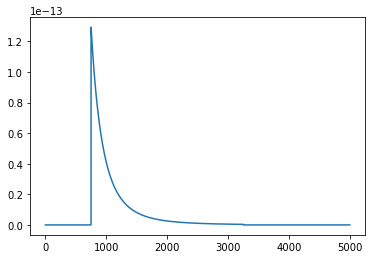

In [38]:
plt.plot(fi,rpsd)